In [96]:
from d2l import torch as d2l
from torch import nn
import numpy as np

#### 8.1.2 Ví dụ
- Sau khi đề cập về lý thuyết, giờ ta sẽ thử lập trình minh họa. Đầu tiên, ta khởi tạo một vài dữ liệu như sau. Để đơn giản, ta tạo chuỗi thời gian bằng cách sử dụng hàm sin cộng thêm một chút nhiễu.

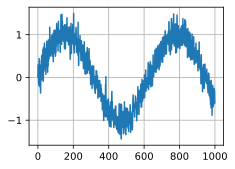

In [97]:
T = 1000 # Generate a total of 1000 points
time = np.arange(0, T)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size = T)
d2l.plot(time, [x])

- Tiếp theo ta cần biến đổi chuỗi thời gian này thành các đặc trưng và nhãn được sử dụng để huấn luyện mạng. Dựa tren kích thước embedding τ, ta ánh xạ dữ liệu thành các cặp . 

- Ta sẽ mất τ điểm dữ liệu đầu tiên bởi vì ta không có đủ τ điểm dữ liệu trong quá khứ để làm đặc trưng cho chúng. 
- Một cách để khắc phục điều này khi chuỗi thời gian rất dài là loại bỏ đi số ít các phần tử đó. Một cách khác là đệm thêm giá trị 0 vào chuỗi thời gian.
- Ta sử dụng kiến trúc đơn giản với vài tầng kết nối đầy đủ, hàm kích hoạt ReLU và hàm mất mát l2. 

In [98]:
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyLinear(10),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
    def forward(self, X):
        return self.net(X)

def get_data_loader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch

tau = 4
# Có tổng cộng T - tau dữ liệu với số lượng thuộc tính là tau
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:]
labels = d2l.torch.tensor(data = labels).type(dtype = torch.float32)
features = d2l.torch.tensor(data = features).type(dtype = torch.float32)
labels = labels.unsqueeze(1)
print(labels.shape, features.shape)
batch_size, n_train = 16, 600

train_iter = get_data_loader(features[:n_train], labels[:n_train], batch_size)
test_iter = get_data_loader(features[n_train:], labels[n_train:], batch_size)

net = MLP()

loss = nn.MSELoss()
lr = 0.01
trainer = d2l.torch.optim.Adam(net.parameters(), lr)

torch.Size([996, 1]) torch.Size([996, 4])


In [100]:
def train(net, train_iter, test_iter, num_epochs):
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # print(X.dtype)
            y_hat = net(X)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
        with d2l.torch.no_grad():
            for X, y in test_iter:
                test_loss = loss(net(X), y)
                break
            print(f"Epoch: {epoch} | MSE Train Loss: {l.detach().numpy()} | MSE Test Loss: {test_loss.detach().numpy()}")
train(net, train_iter, test_iter, 10)
    

Epoch: 0 | MSE Train Loss: 0.04057687148451805 | MSE Test Loss: 0.056229110807180405
Epoch: 1 | MSE Train Loss: 0.053924936801195145 | MSE Test Loss: 0.051466237753629684
Epoch: 2 | MSE Train Loss: 0.03389172628521919 | MSE Test Loss: 0.04494359344244003
Epoch: 3 | MSE Train Loss: 0.04943273216485977 | MSE Test Loss: 0.054673340171575546
Epoch: 4 | MSE Train Loss: 0.035908691585063934 | MSE Test Loss: 0.06440599262714386
Epoch: 5 | MSE Train Loss: 0.038195304572582245 | MSE Test Loss: 0.044065363705158234
Epoch: 6 | MSE Train Loss: 0.06545235216617584 | MSE Test Loss: 0.03817230463027954
Epoch: 7 | MSE Train Loss: 0.07214044034481049 | MSE Test Loss: 0.03711749613285065
Epoch: 8 | MSE Train Loss: 0.052965953946113586 | MSE Test Loss: 0.039768826216459274
Epoch: 9 | MSE Train Loss: 0.0376112163066864 | MSE Test Loss: 0.038995664566755295


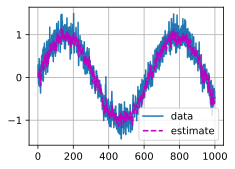

In [101]:
estimate = net(features)
estimate = estimate.detach().numpy()

d2l.plot([time, time[tau:]], [x, estimate],
         legend=['data', 'estimate'])